# L-BFGS vs GD

Curiously, the original L-BFGS convergence proof essentially reduces the L-BFGS iteration to GD. This establishes L-BFGS converges globally for sufficiently regular functions and also that it has local linear convergence, just like GD, for smooth and strongly convex functions.

But if you look carefully at the proof, the construction is very strange: the more memory L-BFGS uses the less it looks like GD, the worse the smoothness constants are for the actual local rate of convergence. I go to into more detail on this in my [SO question](https://scicomp.stackexchange.com/questions/36166/when-does-l-bfgs-outperform-gd) on the topic, but I was curious about some empirical assessments of how these compare.

I found a [study](http://math.furman.edu/~mwoodard/fuejum/content/2007/paper2_2007.pdf) which confirms high-level intuition: L-BFGS interpolates between CG and BFGS as you increase memory. This relationship is true in a limiting sense: when $L=0$ L-BFGS is equal to a flavor of CG (with exact line search) and when $L=\infty$ it's BFGS. BFGS, in turn, iteratively constructs approximations $B_k$ to the Hessian which eventually satisfy a directional inequality $\|(B_k-\nabla_k^2)\mathbf{p}_k\|=o(\|\mathbf{p}_k\|)$ where $\mathbf{p}_k=-B_k^{-1}\nabla_k$ is the descent direction, which it turns out is enough to be "close enough" to Newton that you can achieve superlinear convergence rates.

So, to what extent does agreement between $\mathbf{p}_k,\nabla_k$ (measured as $\cos^2 \theta_k$, the square of the cosine of the angle between the two) explain fast L-BFGS convergence? How about the magnitude of the Hessian-approximate-BFGS-Hessian agreement along the descent direction $\|(B_k-\nabla_k^2)\mathbf{p}_k\|$? What about the secant equation difference?

One interesting hypothesis is that the low-rank view L-BFGS has into the Hessian means that it can't approximate the Hessian well if its eigenvalues are spread far apart (since you need to "spend" rank to explore parts of the eigenspace).

Let's take some simple overdetermined least squares systems with varying eigenspectra and see how all the metrics above respond.

In [1]:
from numpy_ringbuffer import RingBuffer
import numpy as np
from scipy.stats import special_ortho_group
from scipy import linalg as sla
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.optimize import line_search

class LBFGS:
    def __init__(self, m, d, x0, g0):
        self.s = RingBuffer(capacity=m, dtype=(float, d))
        self.y = RingBuffer(capacity=m, dtype=(float, d))
        self.x = x0.copy()
        self.g = g0.copy()
    
    def mvm(self, q):
        q = q.copy()
        m = len(self.s)
        alphas = np.zeros(m, dtype=float)
        for i, (s, y) in enumerate(zip(reversed(self.s), reversed(self.y))):
            inv_rho = s.dot(y)
            alphas[m - i - 1] = s.dot(q) / inv_rho
            q -= alphas[m - i - 1] * y
        if m > 0:
            s = next(reversed(self.s))
            y = next(reversed(self.y))
            gamma = s.dot(y) / y.dot(y)
        else:
            gamma = 1
        z = gamma * q
        for (alpha, s, y) in zip(alphas, self.s, self.y):
            inv_rho = s.dot(y)
            beta = y.dot(z) / inv_rho
            z += s * (alpha - beta)
        return -z
    
    # mvm(self, self.g) gives current lbfgs direction
    # - H g
    
    def update(self, x, g):
        s = x - self.x
        y = g - self.g
        if self.s.is_full:
            assert self.y.is_full
            self.s.popleft()
            self.y.popleft()
        self.s.append(s)
        self.y.append(y)
        self.x = x.copy()
        self.g = g.copy()

In [2]:
from scipy.optimize.linesearch import line_search_armijo

def haar(n, d, rng=np.random):
    # https://nhigham.com/2020/04/22/what-is-a-random-orthogonal-matrix/
    assert n >= d
    z = rng.normal(size=(n, d))
    if n > d:
        q, r = sla.qr(z, mode='economic')
    else:
        q, r = sla.qr(z, mode='full')
    assert q.shape[1] == d, (q.shape[1], d)
    return q

np.random.seed(1234)
d = 100
n = 1000
vt = haar(d, d)
u = haar(n, d)

# bottom singular value we'll keep at 1
# so top determines the condition number
# for a vector s of singular values
# A = u diag(s) vt
# objective = 1/2 ||Ax - 1||_2^2

x0 = np.zeros(d)
b = np.ones(n)

def xopt(A):
    u, s, vt = A
    return vt.T.dot(u.T.dot(b) / s)

def objective(A, x):
    u, s, vt = A
    vtx = vt.dot(x)
    Ax = u.dot(s * vtx)
    diff = Ax - b
    f = diff.dot(diff) / 2
    g = vt.T.dot(s * (s * vtx - u.T.dot(b)))
    return f, g

def hessian_mvm(A, q):
    u, s, vt = A
    return vt.T.dot(s * (s * vt.dot(q)))

def gd(A, max_iter=1000, tol=1e-11, c1=0.2, c2=0.8, armijo=False):
    x = x0.copy()
    xsol = xopt(A)
    fsol = objective(A, xsol)[0]
    gaps = []
    for _ in range(max_iter):
        f, g = objective(A, x)
        gaps.append(abs(f - fsol))
        if gaps[-1] < tol:
            break
        if armijo:
            alpha, *_ = line_search_armijo(
                lambda x: objective(A, x)[0],
                x, -g, g, f)
        else:
            alpha = line_search(
                lambda x: objective(A, x)[0],
                lambda x: objective(A, x)[1],
                x, -g, maxiter=1000,
                c1=c1, c2=c2)
            if alpha[0] is None:
                raise RuntimeError((alpha, g, x))
            alpha = alpha[0]
        x -= alpha * g
    return gaps

def lbfgs(A, m, max_iter=1000, tol=1e-11, extras=False, c1=0.2, c2=0.8, armijo=False):
    x = x0.copy()
    xsol = xopt(A)
    fsol = objective(A, xsol)[0]
    gaps = []
    if extras:
        newton = []
        cosine = []
    
    f, g = objective(A, x)
    opt = LBFGS(m, d, x, g)

    for i in range(max_iter):
        gaps.append(abs(f - fsol))
        p = opt.mvm(opt.g)
        
        if extras:
            newton.append(np.linalg.norm(
                hessian_mvm(A, p) - opt.mvm(p)
            ) / np.linalg.norm(p))
            cosine.append(1 - p.dot(-g) / np.linalg.norm(p) / np.linalg.norm(g))
        if gaps[-1] < tol:
            break 
        if armijo:
            alpha, *_ = line_search_armijo(
                lambda x: objective(A, x)[0],
                x, p, opt.g, f)
        else:
            alpha = line_search(
                lambda x: objective(A, x)[0],
                lambda x: objective(A, x)[1],
                x, p, maxiter=1000,
                c1=c1, c2=c2)
            if alpha[0] is None:
                raise RuntimeError(alpha)
            alpha = alpha[0]
        x += alpha * p
        f, g = objective(A, x)
        opt.update(x, g)
    if extras:
        return gaps, newton, cosine
    return gaps

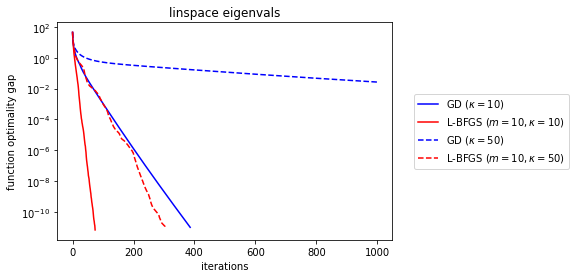

In [3]:
for kappa, ls in [(10, '-'), (50, '--')]:
    s = np.linspace(1, kappa, d)
    A = (u, s, vt)
    gds = gd(A)
    memory = 10
    lbs = lbfgs(A, memory)
    matrix_name = 'linspace eigenvals'
    plt.semilogy(gds, c='b', label=r'GD ($\kappa = {kappa}$)'.format(kappa=kappa), ls=ls)
    plt.semilogy(lbs, c='r', ls=ls,
                 label=r'L-BFGS ($m = {memory}, \kappa = {kappa}$)'.format(
                     kappa=kappa, memory=memory))
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.xlabel('iterations')
plt.ylabel('function optimality gap')
plt.title(matrix_name)
plt.show()

OK, so pretty interestingly, L-BFGS is still fundamentally linear in terms of its convergence rate (which translates to $\log \epsilon^{-1}$ speed for quadratic problems like ours). But clearly it gets better bang for its buck in the rate itself. And this is obviously important---even though the $\kappa = 50$ GD is still "exponentially fast", it's clear that the small slope means it'll still take a practically long time to converge. We know from [explicit analysis](https://calculus.subwiki.org/wiki/Gradient_descent_with_exact_line_search_for_a_quadratic_function_of_multiple_variables) that the GD linear rate will be something like $((\kappa - 1)/\kappa)^2$. If you squint really hard, that's basically $((1-\kappa^{-1})^\kappa)^{2/\kappa}\approx e^{-2/\kappa}$ for large $\kappa$, which is why our "exponential rates" look not-so-exponential, especially for $\kappa$ near the number of iterations (because then the suboptimality gap looks like $r^{T/\kappa}$ for $T$ iterations and $r=e^{-2}$).

It's interesting to compare how sensitive L-BFGS and GD are to the condition number increase. Yes, we're fixing the eigenvalue pattern to be a linear spread, but let's save inspecting that to the end.

The linear rate is effectively the slope that the log plot has at the end. While we're at it, what's the effect of more memory?

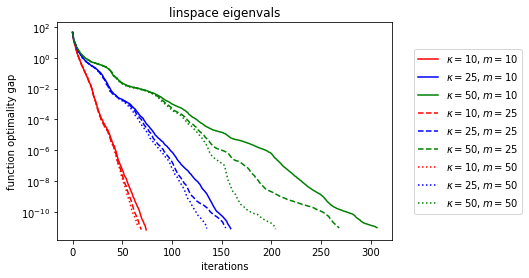

In [4]:
for memory, ls in [(10, '-'), (25, '--'), (50, ':')]:
    for kappa, color in [(10, 'r'), (25, 'b'), (50, 'g')]:
        s = np.linspace(1, kappa, d)
        A = (u, s, vt)
        lbs = lbfgs(A, memory)
        plt.semilogy(lbs, c=color, ls=ls,
                     label=r'$\kappa = {kappa}, m = {memory}$'.format(
                        memory=memory, kappa=kappa))

plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.xlabel('iterations')
plt.ylabel('function optimality gap')
plt.title(matrix_name)
plt.show('linspace eigenvals (L-BFGS)')

Now that's pretty cool, it looks like the limiting behavior is still ultimately linear (as expected, it takes about as many iterations as the memory size for the limiting behavior to "kick in"), but as memory increases, the rate gets better. What if we make the eigenvalues clumpy?

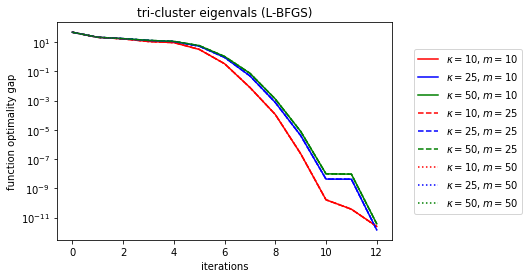

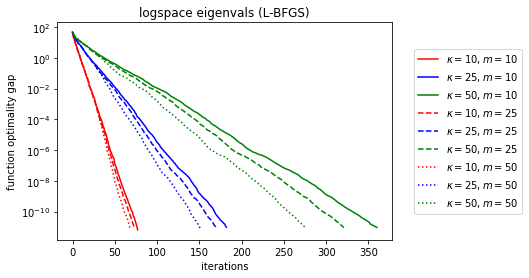

In [5]:
for memory, ls in [(10, '-'), (25, '--'), (50, ':')]:
    for kappa, color in [(10, 'r'), (25, 'b'), (50, 'g')]:
        bot, mid, top = d // 3, d // 3, d - 2 * d // 3
        s = [1] * bot + [kappa / 2] * mid + [kappa] * top
        s = np.array(s)
        A = (u, s, vt)
        lbs = lbfgs(A, memory)
        plt.semilogy(lbs, c=color, ls=ls,
                     label=r'$\kappa = {kappa}, m = {memory}$'.format(
                        memory=memory, kappa=kappa))

plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.xlabel('iterations')
plt.ylabel('function optimality gap')
plt.title('tri-cluster eigenvals (L-BFGS)')
plt.show()

for memory, ls in [(10, '-'), (25, '--'), (50, ':')]:
    for kappa, color in [(10, 'r'), (25, 'b'), (50, 'g')]:
        s = np.logspace(0, np.log10(kappa), d)
        A = (u, s, vt)
        lbs = lbfgs(A, memory)
        plt.semilogy(lbs, c=color, ls=ls,
                     label=r'$\kappa = {kappa}, m = {memory}$'.format(
                        memory=memory, kappa=kappa))

plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.xlabel('iterations')
plt.ylabel('function optimality gap')
plt.title('logspace eigenvals (L-BFGS)')
plt.show()

Wow, done in 12 iterations for the clustered eigenvalues. It looks like the hardest spectrum for L-BFGS (and coincedentally the one with the cleanest descent curves) is evenly log-spaced spectra.

Let's try to map out the relationship between memory, kappa, and the linear convergence rate.

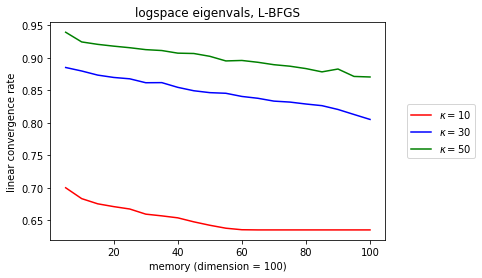

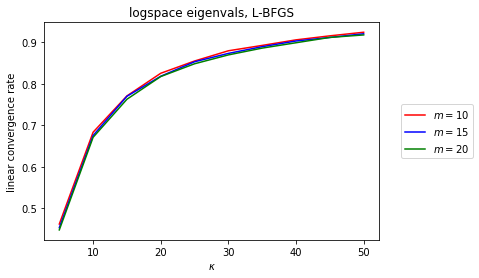

In [6]:
from scipy.stats import linregress

kappa = 30
memory = list(range(5, 100 + 1, 5))
for kappa, color in [(10, 'r'), (30, 'b'), (50, 'g')]:
    rates = []
    for m in memory:
        s = np.logspace(0, np.log10(kappa), d)
        A = (u, s, vt)
        lbs = lbfgs(A, m)
        y = np.log(lbs)
        x = np.arange(len(lbs)) + 1
        slope, *_ = linregress(x, y)
        rates.append(np.exp(slope))
    plt.plot(memory, rates,
             c=color, label=r'$\kappa = {kappa}$'.format(kappa=kappa))

plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.xlabel('memory (dimension = {d})'.format(d=d))
plt.ylabel('linear convergence rate')
plt.title(r'logspace eigenvals, L-BFGS'
          .format(kappa=kappa))
plt.show()

kappas = list(range(5, 50 + 1, 5))
# interestingly, large memory becomes unstable
for memory, color in [(10, 'r'), (15, 'b'), (20, 'g')]:
    rates = []
    for kappa in kappas:
        s = np.logspace(0, np.log10(kappa), d)
        A = (u, s, vt)
        lbs = lbfgs(A, memory)
        y = np.log(lbs)
        x = np.arange(len(lbs)) + 1
        slope, *_ = linregress(x, y)
        rates.append(np.exp(slope))
    
    plt.plot(kappas, rates,
            c = color, label=r'$m = {memory}$'.format(memory=memory))
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.xlabel(r'$\kappa$')
plt.ylabel('linear convergence rate')
plt.title(r'logspace eigenvals, L-BFGS'
          .format(memory=memory))
plt.show()

OK, so the dependence in $\kappa$ still smells like $1-\kappa^{-1}$, but at least there's a very interesting linear trend between the linear convergence rate and memory (which does seem to bottom out for well-conditioned problems, but those don't matter so much). What's cool is that it's preserved across different $\kappa$.

To finish off, just out of curiosity, do any of the BFGS diagnostics tell us much about the convergence rate?

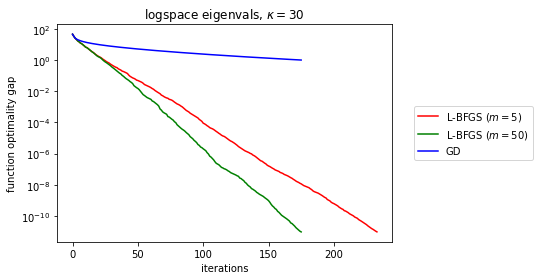

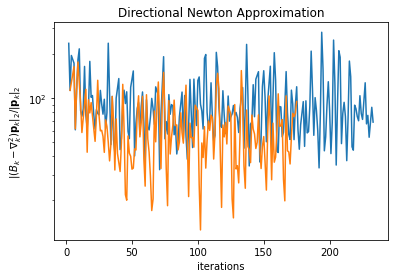

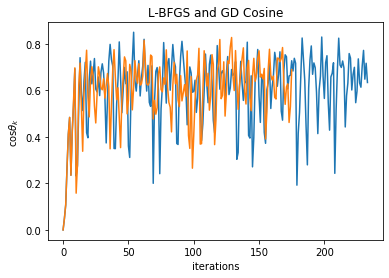

In [7]:
kappa = 30
s = np.logspace(0, np.log10(kappa), d)
A = (u, s, vt)

newtons, cosines = [], []
memories = [5, 50]

for color, memory in zip(['r', 'g'], memories):
    lbs, newton, cosine = lbfgs(A, memory, extras=True)
    matrix_name = r'logspace eigenvals, $\kappa = {kappa}$'.format(kappa=kappa)
    plt.semilogy(lbs, c=color,
                 label=r'L-BFGS ($m = {memory}$)'.format(memory=memory))
    newtons.append(newton)
    cosines.append(cosine)

gds = gd(A, max_iter=len(lbs))
plt.semilogy(gds, c='b', label='GD')
    
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.xlabel('iterations')
plt.ylabel('function optimality gap')
plt.title(matrix_name)
plt.show()


for newton, memory in zip(newtons, memories):
    newton = np.array(newton)
    index = np.arange(len(newton))
    q = np.percentile(newton, 95)
    plt.semilogy(index[newton < q], newton[newton < q],
                 label=r'$m = {memory}$'.format(memory=memory))
plt.xlabel('iterations')
plt.ylabel(r'$\|(B_k -\nabla_k^2)\mathbf{p}_k\|_2/\|\mathbf{p}_k\|_2$')
plt.title('Directional Newton Approximation')
plt.show()

for cosine, memory in zip(cosines, memories):
    cosine = np.array(cosine)
    plt.plot(cosine,
                 label=r'$m = {memory}$'.format(memory=memory))
plt.xlabel('iterations')
plt.ylabel(r'$\cos \theta_k$')
plt.title('L-BFGS and GD Cosine')
plt.show()

So, as we can see above, it's not quite right to look to either $\cos\theta_k$ nor $\|(B_k-\nabla^2_k)\mathbf{p}_k\|/\|\mathbf{p}_k\|$ to demonstrate L-BFGS convergence (the latter should tend to zero per BFGS theory as memory tends to infinity). But at least for quadratic functions, perhaps it's possible to work out the linear rate acceleration observed earlier via some matrix algebra.

A follow-up question by Brian Borchers was what happens in the ill-conditioned regime. Unfortunately, the Wolfe search no longer converges, for GD and L-BFGS. Switching to backtracking-only stabilizes the descent. We end up with noisier curves so I geometrically average over a few samples. Note the rates are all still linear but much worse.

2020-11-01 19:04:02,703	ERROR worker.py:655 -- Calling ray.init() again after it has already been called.


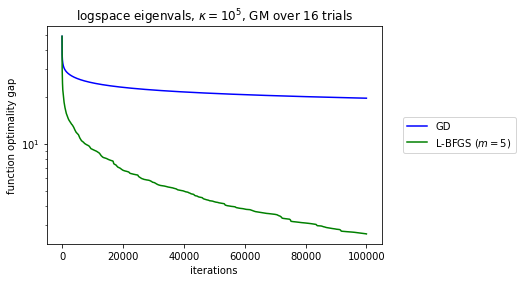

In [9]:
kappa_log10 = 5
s = np.logspace(0, kappa_log10, d)
memory = 5

import ray
ray.init(ignore_reinit_error=True)

# https://vladfeinberg.com/2019/10/20/prngs.html
from numpy.random import SeedSequence, default_rng

ss = SeedSequence(12345)
trials = 16
child_seeds = ss.spawn(trials)
maxit = 1000 * 100

@ray.remote(num_cpus=1)
def descent(A, algo):
    if algo == 'lbfgs':
        return lbfgs(A, memory, armijo=True, max_iter=maxit)
    else:
        return gd(A, max_iter=maxit, armijo=True)

@ray.remote
def trial(seed):
    rng = default_rng(seed)
    
    vt = haar(d, d, rng)
    u = haar(n, d, rng)

    A = (u, s, vt)
    
    lbs = descent.remote(A, 'lbfgs')
    gds = descent.remote(A, 'gd')
    lbs = ray.get(lbs)
    gds = ray.get(gds)
    lbsnp = np.full(maxit, min(lbs))
    gdsnp = np.full(maxit, min(gds))
    lbsnp[:len(lbs)] = lbs
    gdsnp[:len(gds)] = gds
    
    return lbsnp, gdsnp

lbs_gm = np.zeros(maxit)
gds_gm = np.zeros(maxit)
for i, fut in enumerate([trial.remote(seed) for seed in child_seeds]):
    lbs, gds = ray.get(fut)
    lbs_gm += np.log(lbs)
    gds_gm += np.log(gds)
lbs_gm /= trials
gds_gm /= trials

matrix_name = r'logspace eigenvals, $\kappa = 10^{{{kappa_log10}}}$, GM over {trials} trials'.format(kappa_log10=kappa_log10, trials=trials)
plt.semilogy(np.exp(gds_gm), c='b', label='GD')
plt.semilogy(np.exp(lbs_gm), c=color,
             label=r'L-BFGS ($m = {memory}$)'.format(memory=memory))
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.xlabel('iterations')
plt.ylabel('function optimality gap')
plt.title(matrix_name)
plt.show()